In [1]:
import Base: ==, +, *, -, rand
using Distributions
using POMDPs
import POMDPs: create_state, discount, isterminal, pdf, actions, iterator, n_actions, observation, create_observation_distribution
using POMDPToolbox
using GenerativeModels
import GenerativeModels: generate_sor, generate_o, initial_state, generate_s
import POMDPBounds: lower_bound, upper_bound, Bound

In [2]:
type NeedleState
    x::Float64 # x position
    y::Float64 # y position
    psi::Float64 # orientation
    done::Bool # are we in a terminal state?
end
NeedleState(x::Float64, y::Float64, psi::Float64) = NeedleState(x,y,psi,false)

==(s1::NeedleState, s2::NeedleState) = (s1.x == s2.x) && (s1.y == s2.y) && (s1.psi == s2.psi) && (s1.done == s2.done);
posequal(s1::NeedleState, s2::NeedleState) = (s1.x == s2.x) && (s1.y == s2.y) && (s1.psi == s2.psi);
function posnear(s1::NeedleState, s2::NeedleState, epsilon::Float64=5.0)
    if (abs(s1.x - s2.x) < epsilon) && (abs(s1.y - s2.y) < epsilon)
        return true;
    else
        return false;
    end
end
+(s1::NeedleState, s2::NeedleState) = NeedleState(s1.x+s2.x, s1.y+s2.y, s1.psi+s2.psi);
-(s1::NeedleState, s2::NeedleState) = NeedleState(s1.x-s2.x, s1.y-s2.y, s1.psi-s2.psi);

function Base.copy!(s1::NeedleState, s2::NeedleState) 
    s1.x = s2.x
    s1.y = s2.y
    s1.psi = s2.psi
    s1.done = s2.done
    s1
end

# the needle mdp type
type Needle <: POMDP{NeedleState, Symbol, NeedleState} # Note that our MDP is parametarized by the state and the action
    sigmas::Vector{Float64}
    reward_states::Vector{NeedleState} # target/obstacle states
    reward_values::Vector{Float64} # reward values for those states
    tprob::Array{Float64} # probability of transitioning to the desired state
    discount_factor::Float64 # disocunt factor
end


function Needle(;
    sigmas = [10.0, 10.0, 0.5],
    rs::Vector{NeedleState} = [NeedleState(50.0,40.0,0.0); NeedleState(70.0,40.0,0.0); NeedleState(40.0,60.0,0.0);NeedleState(60.0,60.0,0.0)], # goal and obstacle states
    rv::Vector{Float64} = [100.0; -20.0; -20.0; -20.0],
    tp::Array{Float64} = [0.05, 0.9, 0.05, 0.0], # tprob
    discount_factor::Float64 = 0.85)
    return Needle(sigmas, rs, rv, tp, discount_factor)
end;

In [3]:
type ActionSpace <: AbstractSpace
    actions::Vector{Symbol}
end

function POMDPs.actions(pomdp::Needle)
    acts = [:cw, :ccw]
    return ActionSpace(acts)
end;
POMDPs.actions(pomdp::Needle, s::NeedleState, as::ActionSpace=actions(pomdp)) = as;
Base.length(asp::ActionSpace) = length(asp.actions)
iterator(space::ActionSpace) = space.actions
n_actions(p::Needle) = length(actions(p))

function rand(rng::AbstractRNG, asp::ActionSpace, a::Symbol)
    a = rand(rng, iterator(asp))
    return a
end;
rand(rng::AbstractRNG, asp::ActionSpace) = rand(rng, asp, :cw);

In [4]:
# Implements the starting state of the needle
# function initial_state(pomdp::Needle, rng::AbstractRNG)
#     return NeedleState(4.0,10.0,7.0);
# end

function sigma(pomdp::Needle, s::NeedleState, rng::AbstractRNG)
    x = Base.randn(rng)*(pomdp.sigmas[1]);
    y = Base.randn(rng)*(pomdp.sigmas[2]);
    psi = Base.randn(rng)*(pomdp.sigmas[3]);
    return NeedleState(x, y, psi);
end
# Implements the noisy observation
function generate_o(pomdp::Needle, s::NeedleState, a::Symbol, sp::NeedleState, rng::AbstractRNG)
    return sp + sigma(pomdp, sp, rng)
    #return sp;
end

generate_o (generic function with 5 methods)

In [5]:
type NeedleProperties
    length::Float64  # Needle length in mm
    OD::Float64      # Needle Outer diam in mm
    ID::Float64      # Needle Inner diam in mm
    E::Float64       # Young's Modulus
    NeedleProperties() = new()
    NeedleProperties(l,od,id,e) = new(l,od,id,e)
end
MomInertia(np::NeedleProperties) = pi/4*((np.OD/1000)^4 - (np.ID/1000)^4);

function SimpleNeedle(F::Float64, dir::Int64, np::NeedleProperties, v::Float64=2.0)
    # Inputs
    # F: bevel tip load [N]
    # dir: bevel tip orientation +1 ccw, cw -1
    # np: Needle mechanical properties
    # Outputs
    # w: needle tip deflection [mm]
    # theta: tip angle [rad]
    w = (F*dir)*(v/1000)^3/(3*np.E*MomInertia(np))*1000; # in mm
    theta = (F*dir)*(v/1000)^2/(2*np.E*MomInertia(np))
    return w, theta
end;

np = NeedleProperties(200.0,0.9,0.6,3e9)

function advance_needle(s::NeedleState, a::Symbol, rng::AbstractRNG)
    psi = s.psi
    R = zeros(2,2)
    R[1,1] = cos(psi); R[1,2] = -sin(psi); R[2,1] = sin(psi); R[2,2] = cos(psi);
    F = 40.0 + Base.randn(rng)*5; # TODO add more uncertainty if needed
    dir = 1;
    if a == :cw
        dir = 1;
    elseif a == :ccw
        dir = -1;
    end
    w, theta = SimpleNeedle(F, dir, np);
    gradient = R*[2.0; w];
    dx = gradient[1];
    dy = gradient[2];
    return NeedleState(s.x+dx, s.y+dy, psi+theta)    
end;

In [6]:
function generate_sor(pomdp::Needle, s, a, rng::AbstractRNG, sp=nothing, o=nothing)
    if s.done                  # Terminal state
        sprime = copy(s);
        o = generate_o(pomdp, s, a, sprime, rng);
        r = 0;
        return (sprime, o, r);
    end
    sprime = advance_needle(s, a, rng);
    o = generate_o(pomdp, s, a, sprime, rng);
    r = -0.1 # penalize for any state but the goal state
    for (i, rs) in enumerate(pomdp.reward_states)
        if posnear(rs, s)
            r = pomdp.reward_values[i]
            sprime.done = true;
        end
    end
    if (out_of_bounds(s))
        sprime.done = true;
        r = -100;
    end
    return (sprime, o, r)
end;

function generate_s(pomdp::Needle, s::NeedleState, a::Symbol, rng::AbstractRNG)
    return advance_needle(s, a, rng)
end

generate_s (generic function with 3 methods)

In [7]:
function out_of_bounds(s::NeedleState)
    return (s.x > 100.0) || (s.x < 0.0) || (s.y > 100.0) || (s.y < 0.0);
end

out_of_bounds (generic function with 1 method)

In [8]:
type ObsDistribution <: AbstractDistribution
    #curr_obs::NeedleState # the current observation
    μs::Array{Float64} # the states s' in the distribution
    σs::Array{Float64} # the probability corresponding to each state s'
end

function POMDPs.create_observation_distribution(pomdp::Needle)
    # 27 potential observations
    # initialize to whatever
    
    return ObsDistribution([0.0, 0.0, 0.0],[1.0, 1.0, 1.0])
end;

function POMDPs.pdf(d::ObsDistribution, s::NeedleState)
    mus = d.μs;
    covM = Matrix{Float64}([(d.σs[1])^2 0 0; 0 (d.σs[2])^2 0; 0 0 (d.σs[3])^2]);
    distMV = MvNormal(mus, covM);
    return Distributions.pdf(distMV, [s.x, s.y, s.psi]);
end;

function POMDPs.observation(pomdp::Needle,
                            s::NeedleState,
                            action::Symbol,
                            sp::NeedleState,
                            od::ObsDistribution)
    x = sp.x;
    y = sp.y;
    psi = sp.psi;
    d = ObsDistribution([x, y, psi], pomdp.sigmas); # Arbitrary standard distributions
    return d;
end



In [9]:
type NeedleLowerBound <: Bound
    rng::AbstractRNG
end

type NeedleUpperBound <: Bound
    rng::AbstractRNG
end

function lower_bound(lb::NeedleLowerBound, pomdp::Needle, s::NeedleState)
    return -200.0;
end

function upper_bound(ub::NeedleUpperBound, pomdp::Needle, s::NeedleState)
    return 100.0;
end


# function gauss(μ::Float64, σ::Float64)
#     return (1/(σ*sqrt(2*pi)))*exp(-1*μ^2/(2*σ^2));
# end

# # This encodes the belief state. Use multivariate normal distribution.
# # Returns a probability. TODO ask in office hours
# function pdf(s::NeedleState, obs::NeedleState)
#     sigma = [obs.x, obs.y, obs.psi];
#     covM = Matrix{Float64}([(s.x-obs.x)^2 0 0; 0 (s.y-obs.y)^2 0; 0 0 (s.psi-obs.psi)^2]);
#     distMV = MvNormal(sigma, covM);
#     return pdf(distMV, [s.x, s.y, s.sigma]);
# end


upper_bound (generic function with 2 methods)

In [10]:
type InitialStateDistribution <: AbstractDistribution
    states::Array{NeedleState}
    probs::Array{Float64}
end
POMDPs.iterator(d::InitialStateDistribution) = d.states

function POMDPs.initial_state_distribution(pomdp::Needle, state::NeedleState)
    s = [state];
    p = [1.0];
    return InitialStateDistribution(s,p);
end
POMDPs.initial_state_distribution(pomdp::Needle) = initial_state_distribution(pomdp, NeedleState(40.0,100.0,3*pi/2));

function rand(rng::AbstractRNG, d::InitialStateDistribution, s::NeedleState)
    cat = Categorical(d.probs) # init the categorical distribution
    ns = d.states[Base.rand(cat)] # sample a neighbor state according to the distribution c
    copy!(s, ns)
    return s # return the pointer to s
end;
rand(rng::AbstractRNG, d::InitialStateDistribution) = rand(rng, d, NeedleState(1.0,1.0,1.0))
function POMDPs.pdf(d::InitialStateDistribution, s::NeedleState)
    for (i, sp) in enumerate(d.states)
        if posequal(s, sp)
            return d.probs[i];
        end
    end
    return 0.0
end;

In [11]:
POMDPs.create_state(pomdp::Needle) = NeedleState(40.0,100.0,3*pi/2);
POMDPs.create_observation(pomdp::Needle) = NeedleState(40.0,100.0,3*pi/2);
POMDPs.create_action(pomdp::Needle) = :cw;
POMDPs.discount(pomdp::Needle) = pomdp.discount_factor;

function POMDPs.isterminal(pomdp::Needle, s::NeedleState)
    s.done ? (return true) : (return false)
end;

In [12]:
using POMCP
solver = POMCPDPWSolver();
pomdp = Needle();
policy = solve(solver, pomdp);

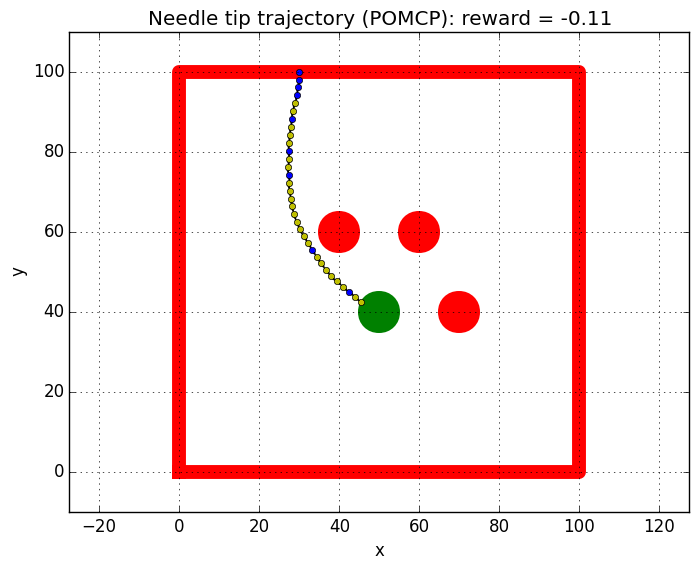

In [14]:
up = SIRParticleUpdater(pomdp, 500);
hist_POMCP = HistoryRecorder();
is=initial_state_distribution(pomdp, NeedleState(30.0,100.0,3*pi/2))
r = simulate(hist_POMCP, pomdp, policy, up, is);

# define tissue environment
using PyPlot
plot([0.0 100.0 100.0 0.0 0.0]',[0.0 0.0 100.0 100.0 0.0]',linewidth=10,color="r") # tissue bounds
plot(pomdp.reward_states[1].x,pomdp.reward_states[1].y,marker="o",markersize=30,color="g",markeredgecolor="none")
plot(pomdp.reward_states[2].x,pomdp.reward_states[2].y,marker="o",markersize=30,color="r",markeredgecolor="none")
plot(pomdp.reward_states[3].x,pomdp.reward_states[3].y,marker="o",markersize=30,color="r",markeredgecolor="none")
plot(pomdp.reward_states[4].x,pomdp.reward_states[4].y,marker="o",markersize=30,color="r",markeredgecolor="none")


# needle trajectory
steps = length(hist_POMCP.state_hist)
for i = 1:steps-1 
    state = hist_POMCP.state_hist[i]
    action = hist_POMCP.action_hist[i]
    if action == :cw
        c = "y"
    else
        c = "b"
    end
    plot(state.x,state.y,color=c,marker="o",markersize=5)
    quiver(state.x,state.y,0.5*cos(state.psi),0.5*sin(state.psi),scale=40)
end

title(@sprintf("Needle tip trajectory (POMCP): reward = %0.2f",r))
axis("equal")
axis([-10.0, 110.0, -10.0, 110.0])
xlabel("x")
ylabel("y")
grid(true)
savefig("Optimal POMCP plot")

In [ ]:
# define tissue environment
using PyPlot
plot([0.0 100.0 100.0 0.0 0.0]',[0.0 0.0 100.0 100.0 0.0]',linewidth=10,color="r") # tissue bounds
plot(pomdp.reward_states[1].x,pomdp.reward_states[1].y,marker="o",markersize=30,color="g",markeredgecolor="none")
plot(pomdp.reward_states[2].x,pomdp.reward_states[2].y,marker="o",markersize=30,color="r",markeredgecolor="none")
plot(pomdp.reward_states[3].x,pomdp.reward_states[3].y,marker="o",markersize=30,color="r",markeredgecolor="none")
plot(pomdp.reward_states[4].x,pomdp.reward_states[4].y,marker="o",markersize=30,color="r",markeredgecolor="none")


# needle trajectory
steps = length(hist_POMCP.state_hist)
for i = 1:steps-1 
    state = hist_POMCP.state_hist[i]
    action = hist_POMCP.action_hist[i]
    if action == :cw
        c = "y"
    else
        c = "b"
    end
    plot(state.x,state.y,color=c,marker="o",markersize=5)
    quiver(state.x,state.y,0.5*cos(state.psi),0.5*sin(state.psi),scale=40)
end

title(@sprintf("Needle tip trajectory (POMCP): reward = %0.2f",r))
axis("equal")
axis([-10.0, 110.0, -10.0, 110.0])
xlabel("x")
ylabel("y")
grid(true)
savefig("Optimal POMCP plot")